In [1]:
from ceruleanml import data
from icevision.parsers import COCOMaskParser
from icevision.data import SingleSplitSplitter
from fastai.data.block import DataBlock
from fastai.vision.data import ImageBlock, MaskBlock
from fastai.vision.augment import aug_transforms
from fastai.vision.learner import unet_learner
from fastai.data.transforms import RandomSplitter
from fastai.metrics import Dice
from ceruleanml.coco_load_fastai import record_collection_to_record_ids, get_image_path, record_to_mask
from torchvision.models import resnet18, resnet34, resnet50
from fastai.callback.fp16 import MixedPrecision
from fastai.callback.tensorboard import TensorBoardCallback
from datetime import datetime
from pathlib import Path
import os

### Parsing COCO Dataset with Icevision

In [2]:
data_path = "/root/"
mount_path = "/root/data"

In [3]:
size = 64  # Progressive resizing could happen here
augs = aug_transforms(flip_vert=True, max_warp=0.1, size=size)
class_map = {v: k for k, v in data.class_mapping_coco_inv.items()}
class_ints = list(range(1, len(list(class_map.keys())[:-1]) + 1))
parser = COCOMaskParser(annotations_filepath=f"{data_path}/tile-cerulean-v2-partial-with-context/instances_Tiled Cerulean Dataset V2.json", img_dir=f"{mount_path}/tile-cerulean-v2-partial-with-context/tiled_images")
train_records, valid_records = parser.parse(autofix=False)

  0%|          | 0/3883 [00:00<?, ?it/s]

### Importing functions for returning an image sample and a semantic segmentation label for each sample

In [4]:
record_ids = record_collection_to_record_ids(train_records)

### Constructing a FastAI DataBlock that uses parsed COCO Dataset from icevision parser+

In [14]:
def get_image_by_record_id(record_id):
    return get_image_path(train_records, record_id)
def get_mask_by_record_id(record_id):
    return record_to_mask(train_records, record_id)

In [16]:
coco_seg_dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=class_ints)),
    get_x=get_image_by_record_id,
    splitter=RandomSplitter(),
    get_y=get_mask_by_record_id,
    batch_tfms=aug_transforms(),
    n_inp=1,
)

dls = coco_seg_dblock.dataloaders(source=record_ids, batch_size=2)

/root/miniconda3/envs/fastai2/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [6]:
get_da_y = lambda record_id: record_to_mask(train_records, record_id)

In [7]:
#dls.one_batch()

### Fastai2 Trainer

In [8]:
#coco_seg_dblock.summary(source=record_ids)

In [9]:
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")
experiment_dir =  Path(f'{mount_path}/experiments/cv2/'+timestampStr+'_fastai_unet/')
experiment_dir.mkdir(exist_ok=True)

In [10]:
arch = 18
archs = {18: resnet18, 34: resnet34, 50: resnet50}

epoch,train_loss,valid_loss,dice,time
0,0.168011,0.150556,0.000000,06:53


epoch,train_loss,valid_loss,dice,time
0,0.098357,0.127017,0.000620,07:08
1,0.080391,0.148397,0.033740,07:08
2,0.088252,0.125780,0.156555,07:09
3,0.092909,0.114992,0.212708,07:08
4,0.074014,0.116270,0.257867,07:08


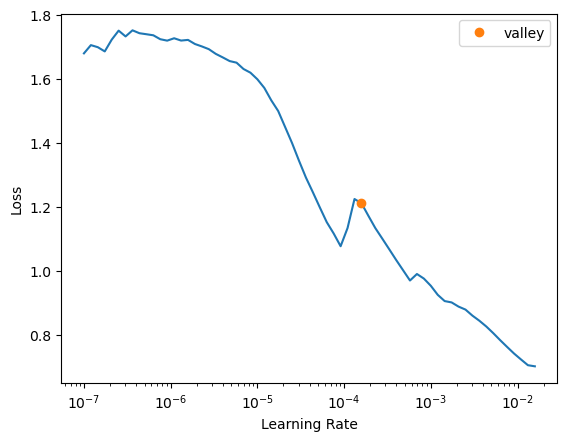

In [11]:
learn = unet_learner(dls, archs[arch], metrics=[Dice()], model_dir=experiment_dir, n_out = 7) # cbs=[MixedPrecision]

lr = learn.lr_find()

cbs = [TensorBoardCallback(projector=False, trace_model=False)]

learn.fine_tune(5, 2e-4, cbs=cbs)#, cbs=SaveModelCallback(monitor='dice'))w

In [17]:
savename = f'{arch}_{size}_{round(learn.validate()[1],3)}.pkl'
learn.export(f'{experiment_dir}/{savename}')

learn.show_results(max_n=4, figsize=(20,20), vmin=0, vmax=3)

/root/miniconda3/envs/fastai2/lib/python3.9/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


TypeError: type NoneType doesn't define __round__ method

## CV1 Parser

In [ ]:
mount_path = "/root/data/cv1_transfer/"
ml_data_path = os.path.join(mount_path, "labeled_data")
path = Path(ml_data_path)
oil_chps = np.loadtxt(path/'oil_chps.txt', dtype=str)
codes = np.loadtxt(path/'codes.txt', dtype=str)
valid_names = np.loadtxt(path/'valid_names.txt', dtype=str)

In [ ]:
import skimage.io as skio
import numpy as np
import dask

labels = path/"lbl"
labels_no_3 = path/"lbl_no3"

os.makedirs(labels_no_3, exist_ok=True)

vals = set()
lazy_results = []
for i in list(labels.glob("*.png"))[0:100]:
    arr = skio.imread(i)
    values = np.unique(arr)
    # I think this was setting a class we didn't need to 0 
    # for the purposes of recreating Jona's binary classifier
    arr[arr==3] = 0
    try:
        lazy_result = dask.delayed(skio.imsave)(labels_no_3 / i.name, arr, check_contrast=False)
        lazy_results.append(lazy_result)
    except:
        continue
computed_results = dask.compute(*lazy_results)

In [ ]:
random.seed(42)
oilless_chps = [chp for chp in get_image_files(path/'chp') if chp.stem not in oil_chps]
density = 0
num_oilless = density * len(oil_chps)
mixed_chps = random.sample(oilless_chps,num_oilless) + [path/'chp'/(chp+'.png') for chp in oil_chps]
len(mixed_chps)

In [ ]:
codes

In [ ]:
def get_chps(path): return mixed_chps
def get_lbls(fn): return fn.parent.parent/"lbl_no3"/f"{fn.name}"
def splitter_func(fn): return fn.name.rsplit('_',1)[0] in valid_names # XXX Check to make sure this should be returning True for Valid

drive_files = get_chps(path)

In [ ]:
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")
lcl =  Path('/root/data/experiments/cv1/'+timestampStr+'/')
#lcl = Path("../out_data")
lcl.mkdir(exist_ok=True)
modelpath = lcl

use_lcl = False
if use_lcl:
  path = lcl
  lcl_chp = path/"chp"
  lcl_lbl = path/"lbl_no3"
  lcl_chp.mkdir(exist_ok=True)
  lcl_lbl.mkdir(exist_ok=True)
  for i, f in enumerate(drive_files): # 10 minutes?!
    if not i%50: print(i, f)
    if not (lcl_chp/f.name).exists():
      copyfile(f, lcl_chp/f.name)
    if not (lcl_lbl/f.name).exists():
      copyfile(get_lbls(f), lcl_lbl/f.name)

In [ ]:
seg_db = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=codes)),
    get_items = get_chps,
    splitter=FuncSplitter(splitter_func),
    batch_tfms=augs,
    get_y=get_lbls)

In [ ]:
dls = SegmentationDataLoaders.from_dblock(
    dblock = seg_db,
    source = path,
    path = path,
    bs = 4)

In [ ]:
seg_db.summary(path)

In [ ]:
dls.show_batch(vmin=0, vmax=3)

In [ ]:
# add best model callback saver
# write to drive not lcl

In [ ]:
arch = 18
archs = {18: resnet18, 34: resnet34, 50: resnet50}

learn = unet_learner(dls, archs[arch], metrics=[Dice()], model_dir=modelpath, cbs=[MixedPrecision])

lr = learn.lr_find()

lr

cbs = [TensorBoardCallback(projector=False, trace_model=False)]


learn.fine_tune(5, 2e-4, cbs=cbs)#, cbs=SaveModelCallback(monitor='dice'))w

# learn.load("model")

In [ ]:
learn

In [ ]:
savename = f'{density}_{arch}_{size}_{round(learn.validate()[1],3)}.pkl'
learn.export(f'{modelpath}/{savename}')

In [ ]:
ls {modelpath}

In [ ]:
learn.show_results(max_n=4, figsize=(20,20), vmin=0, vmax=3)

Default path for tensorboard logs is `./runs/`

In [ ]:
!ls './runs/'

Copy logs to appropriate exeriments folder in the mounted GCS volume.

In [ ]:
!cp -R './runs/' {modelpath}'/tensorboard/'

Now, run the following from anywhere with gcs authenticated:

In [ ]:
!tensorboard --logdir="/root/data/experiments/cv1/09_Mar_2022_18_32_17/tensorboard"
